## Magnitude/Phase frequency representation demo

This notebook samples data from the `SignalSampler` and applies the `SignalConvolutionTask` in **frequency domain with magnitude/phase representation** (`freq_representation="mag_phase"`).

We:
- Create a small synthetic frequency-domain batch using the data sampler.
- Apply the convolution task to get targets in the same mag/phase representation.
- Visualize the **magnitude** and **phase** of inputs/outputs.
- Convert back to the **time domain** to verify everything is consistent.


xs shape: torch.Size([4, 5, 22])
ys shape: torch.Size([4, 5, 22])


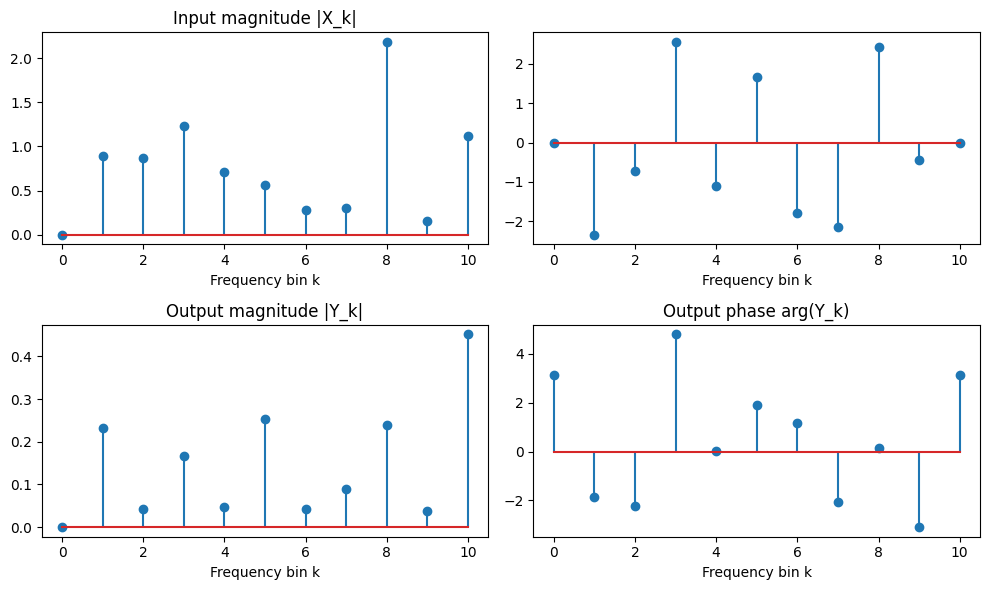

xs_time shape: torch.Size([4, 5, 20])
ys_time shape: torch.Size([4, 5, 20])


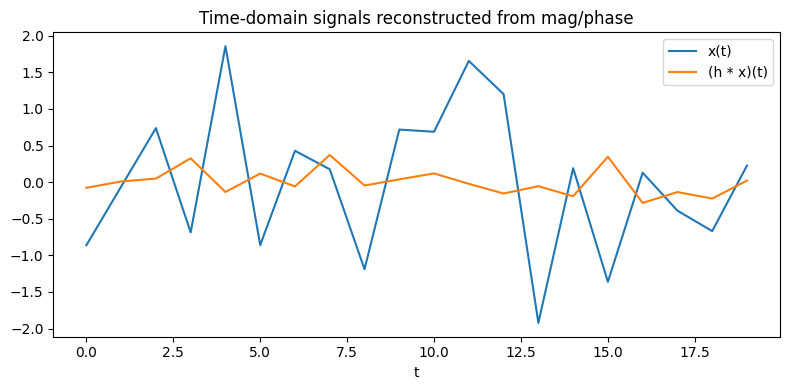

In [2]:
import torch
import matplotlib.pyplot as plt

from samplers import get_data_sampler
from tasks import get_task_sampler

# Basic config for the demo
p = 20
fir_len = 20
batch_size = 4
n_points = 5

# We work in frequency domain with magnitude/phase representation
domain = "freq"
freq_representation = "mag_phase"

# Derived dims: rfft length p_fft = p//2 + 1, so n_dims = 2 * p_fft
p_fft = p // 2 + 1
n_dims = 2 * p_fft

# Device selection
device = "cuda" if torch.cuda.is_available() else "cpu"

# Build data sampler
data_sampler = get_data_sampler(
    "signal",
    n_dims=n_dims,
    p=p,
    domain=domain,
    num_freqs=p,
    device=device,
    freq_representation=freq_representation,
)

# Build task sampler
task_sampler = get_task_sampler(
    "signal_conv",
    n_dims,
    batch_size,
    p=p,
    fir_len=fir_len,
    domain=domain,
    device=device,
    freq_representation=freq_representation,
)

# Sample one task and a batch of inputs
task = task_sampler()
xs = data_sampler.sample_xs(n_points=n_points, b_size=batch_size)  # (B, T, 2*p_fft)
ys = task.evaluate(xs)  # (B, T, 2*p_fft)

print("xs shape:", xs.shape)
print("ys shape:", ys.shape)

# --- Helper: mag/phase -> time domain ---
def magphase_to_time(arr: torch.Tensor, p: int) -> torch.Tensor:
    """Convert interleaved [mag, phase] rFFT representation back to time domain.

    arr: (B, T, 2*p_fft)
    returns: (B, T, p) real time-domain signals
    """
    mag = arr[..., 0::2]
    phase = arr[..., 1::2]
    Z = torch.polar(mag, phase)
    return torch.fft.irfft(Z, n=p, dim=-1, norm="ortho").real

# Pick a single example to visualize
b_idx, t_idx = 0, 0

x_mag = xs[b_idx, t_idx, 0::2].cpu().numpy()
x_phase = xs[b_idx, t_idx, 1::2].cpu().numpy()
y_mag = ys[b_idx, t_idx, 0::2].cpu().numpy()
y_phase = ys[b_idx, t_idx, 1::2].cpu().numpy()

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

axes[0, 0].stem(x_mag)
axes[0, 0].set_title("Input magnitude |X_k|")
axes[0, 0].set_xlabel("Frequency bin k")

axes[0, 1].stem(x_phase)
axes[0, 1].set_xlabel("Frequency bin k")

axes[1, 0].stem(y_mag)
axes[1, 0].set_title("Output magnitude |Y_k|")
axes[1, 0].set_xlabel("Frequency bin k")

axes[1, 1].stem(y_phase)
axes[1, 1].set_title("Output phase arg(Y_k)")
axes[1, 1].set_xlabel("Frequency bin k")

plt.tight_layout()
plt.show()

# --- Time-domain reconstruction check ---
xs_time = magphase_to_time(xs, p)
ys_time = magphase_to_time(ys, p)

print("xs_time shape:", xs_time.shape)
print("ys_time shape:", ys_time.shape)

plt.figure(figsize=(8, 4))
plt.plot(xs_time[b_idx, t_idx].cpu().numpy(), label="x(t)")
plt.plot(ys_time[b_idx, t_idx].cpu().numpy(), label="(h * x)(t)")
plt.title("Time-domain signals reconstructed from mag/phase")
plt.xlabel("t")
plt.legend()
plt.tight_layout()
plt.show()
